In [2]:
import os
import pandas as pd

base_dir = '/global/homes/b/billmj/fl_unsw/experiments'

def parse_experiment_name(folder_name):
    parts = folder_name.split('_')
    num_clients = int(parts[2].replace('clients', ''))
    batch_size = int(parts[3].replace('batchsize', ''))
    return num_clients, batch_size

def load_experiment_data(exp_dir):
    final_metrics = pd.read_csv(os.path.join(exp_dir, 'final_metrics.csv'))
    comm_metrics = pd.read_csv(os.path.join(exp_dir, 'communication_metrics.csv'))
    num_clients, batch_size = parse_experiment_name(os.path.basename(exp_dir))
    
    final_metrics['experiment'] = f'{num_clients}clients_{batch_size}batchsize'
    final_metrics['num_clients'] = num_clients
    final_metrics['batch_size'] = batch_size
    
    comm_metrics['experiment'] = f'{num_clients}clients_{batch_size}batchsize'
    comm_metrics['num_clients'] = num_clients
    comm_metrics['batch_size'] = batch_size
    
    return final_metrics, comm_metrics

all_final_metrics = []
all_comm_metrics = []
experiment_summaries = []

for exp_folder in os.listdir(base_dir):
    if exp_folder.startswith('baseline_experiment_'):
        exp_dir = os.path.join(base_dir, exp_folder)
        final_metrics, comm_metrics = load_experiment_data(exp_dir)
        all_final_metrics.append(final_metrics)
        all_comm_metrics.append(comm_metrics)
        
        num_clients, batch_size = parse_experiment_name(exp_folder)
        final_accuracy = final_metrics['Accuracy'].iloc[-1]
        total_comm_time = comm_metrics['Communication_Time(s)'].sum()
        experiment_summaries.append({
            'Experiment': f'{num_clients} clients, {batch_size} batch size',
            'Final Accuracy': final_accuracy,
            'Total Communication Time (s)': total_comm_time
        })

final_metrics_df = pd.concat(all_final_metrics, ignore_index=True)
comm_metrics_df = pd.concat(all_comm_metrics, ignore_index=True)

print("Data loaded successfully!")
print(f"Final metrics shape: {final_metrics_df.shape}")
print(f"Communication metrics shape: {comm_metrics_df.shape}")

print("\nExperiment Summaries:")
summary_df = pd.DataFrame(experiment_summaries)
print(summary_df.to_string(index=False))

print("\nUnique Experiment Setups:")
unique_setups = final_metrics_df[['num_clients', 'batch_size']].drop_duplicates()
print(unique_setups.to_string(index=False))

Data loaded successfully!
Final metrics shape: (180, 10)
Communication metrics shape: (180, 12)

Experiment Summaries:
                 Experiment  Final Accuracy  Total Communication Time (s)
100 clients, 128 batch size        0.938544                      0.148020
100 clients, 256 batch size        0.857776                      0.165011
  10 clients, 32 batch size        0.985061                      0.018605
 50 clients, 256 batch size        0.937572                      0.081959
  10 clients, 64 batch size        0.976984                      0.016365
 10 clients, 128 batch size        0.984575                      0.017025
 10 clients, 256 batch size        0.970061                      0.017046
 100 clients, 64 batch size        0.953483                      0.153359
  50 clients, 32 batch size        0.965082                      0.080220
 100 clients, 32 batch size        0.956337                      0.159909
  50 clients, 64 batch size        0.960527                      0.

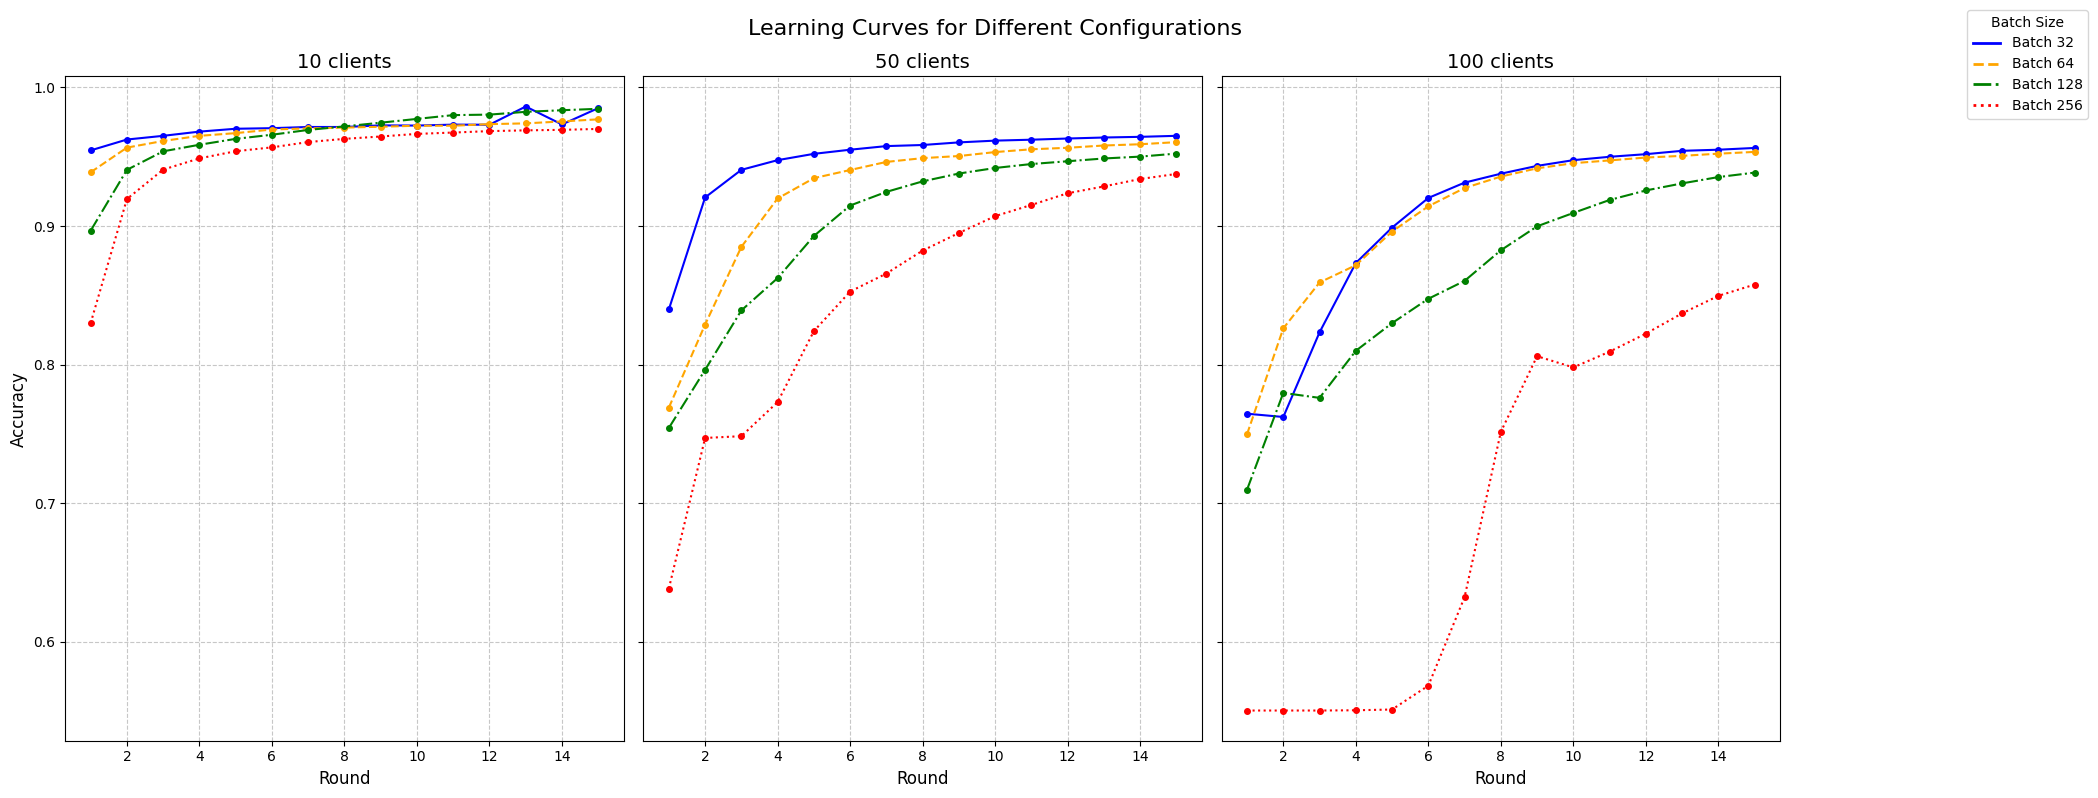


Best performing configurations (based on final accuracy):
 num_clients  batch_size  Accuracy
          10          32  0.986215
          10          64  0.976984
          10         128  0.984575
          10         256  0.970061
          50          32  0.965082
          50          64  0.960527
          50         128  0.952268
          50         256  0.937572
         100          32  0.956337
         100          64  0.953483
         100         128  0.938544
         100         256  0.857776

Worst performing configurations (based on final accuracy):
 num_clients  batch_size  Accuracy
          10          32  0.954576
          10          64  0.938787
          10         128  0.896642
          10         256  0.830024
          50          32  0.839862
          50          64  0.768993
          50         128  0.754357
          50         256  0.638489
         100          32  0.762252
         100          64  0.749863
         100         128  0.709844
      

In [7]:
#1. Learning Curves

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Define color scheme and line styles
colors = {32: 'blue', 64: 'orange', 128: 'green', 256: 'red'}
line_styles = {32: '-', 64: '--', 128: '-.', 256: ':'}

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True)

# Titles for subplots
titles = {0: '10 clients', 1: '50 clients', 2: '100 clients'}
clients = [10, 50, 100]

for idx, ax in enumerate(axes):
    num_clients = clients[idx]
    for batch_size, group in final_metrics_df[final_metrics_df['num_clients'] == num_clients].groupby('batch_size'):
        ax.plot(group['Round'], group['Accuracy'], 
                color=colors[batch_size],
                linestyle=line_styles[batch_size],
                marker='o', markersize=4,
                label=f'Batch {batch_size}')
    ax.set_title(titles[idx], fontsize=14)
    ax.set_xlabel('Round', fontsize=12)
    if idx == 0:
        ax.set_ylabel('Accuracy', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)

# Create legends
batch_legend = [Line2D([0], [0], color=colors[batch], lw=2, linestyle=line_styles[batch], label=f'Batch {batch}') 
                for batch in colors.keys()]

fig.legend(handles=batch_legend, title='Batch Size', loc='upper right', bbox_to_anchor=(1.05, 1))
fig.suptitle('Learning Curves for Different Configurations', fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

# Print some statistics
best_config = final_metrics_df.loc[final_metrics_df.groupby(['num_clients', 'batch_size'])['Accuracy'].idxmax()]
print("\nBest performing configurations (based on final accuracy):")
print(best_config[['num_clients', 'batch_size', 'Accuracy']].to_string(index=False))

worst_config = final_metrics_df.loc[final_metrics_df.groupby(['num_clients', 'batch_size'])['Accuracy'].idxmin()]
print("\nWorst performing configurations (based on final accuracy):")
print(worst_config[['num_clients', 'batch_size', 'Accuracy']].to_string(index=False))


Insights from the plots:
1. **Smaller Batch Sizes**: Configurations with smaller batch sizes (32, 64) tend to reach higher accuracies faster across all client configurations.
2. **Number of Clients**: Configurations with fewer clients (10 clients) generally achieve higher final accuracies compared to those with more clients (50, 100 clients).
3. **Larger Batch Sizes**: Configurations with larger batch sizes (256) show slower convergence and lower final accuracies, especially with higher client counts.

The additional printed statistics highlight the best and worst performing configurations:
- **Best performing configuration**: 10 clients with a batch size of 32, achieving an accuracy of 0.986215.
- **Worst performing configuration**: 100 clients with a batch size of 256, achieving an accuracy of 0.550495.

These insights help to understand the impact of different batch sizes and the number of clients on the performance of federated learning models.



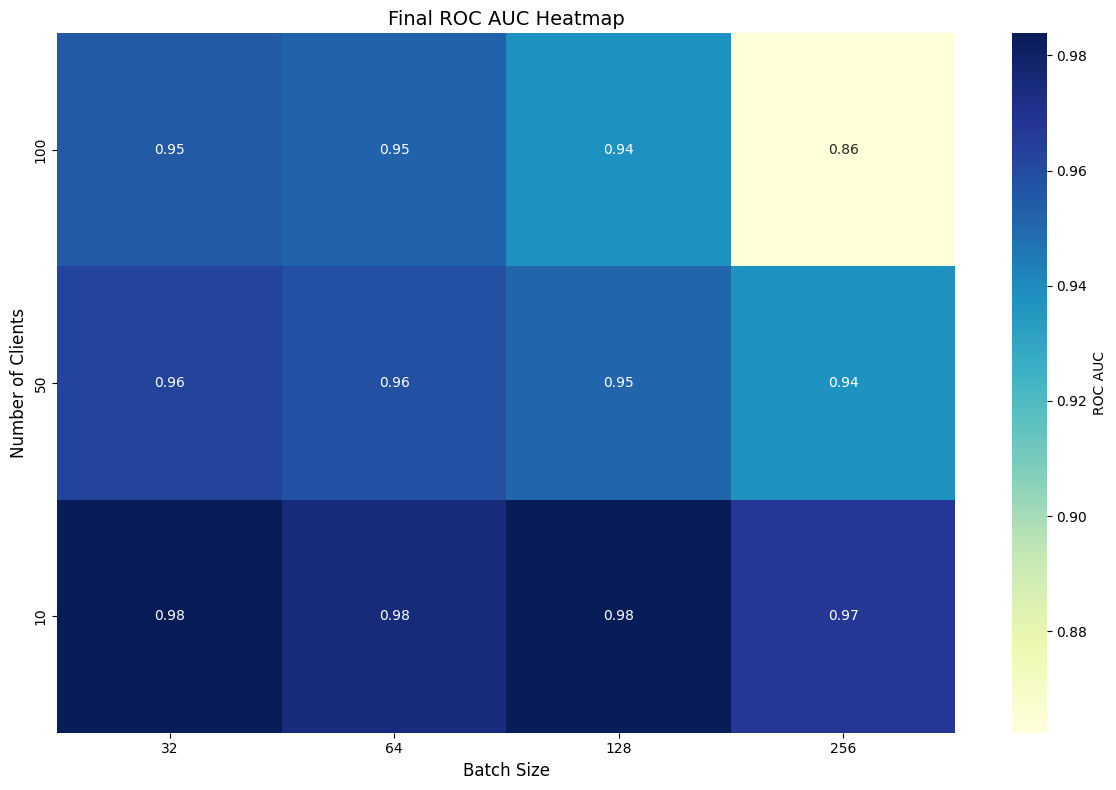


Best configuration based on ROC AUC:
Number of clients: 10, Batch size: 32, ROC AUC: 0.9838


In [12]:
#2.Performance Comparison Heatmap

import seaborn as sns

# Create a pivot table for the heatmap with ROC AUC values
pivot_df_auc = final_metrics_df[final_metrics_df['Round'] == 15].pivot(index='num_clients', columns='batch_size', values='ROC_AUC')

# Reorder the y-axis from 10 to 100
pivot_df_auc = pivot_df_auc.sort_index(ascending=False)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df_auc, annot=True, cmap='YlGnBu', fmt='.2f', cbar_kws={'label': 'ROC AUC'})
plt.title('Final ROC AUC Heatmap', fontsize=14)
plt.xlabel('Batch Size', fontsize=12)
plt.ylabel('Number of Clients', fontsize=12)
plt.tight_layout()
plt.show()

print("\nBest configuration based on ROC AUC:")
best_batch_size_auc = pivot_df_auc.max().idxmax()  # Batch size with the highest ROC AUC
best_num_clients_auc = pivot_df_auc[best_batch_size_auc].idxmax()  # Number of clients for that batch size
best_roc_auc = pivot_df_auc.max().max()  # The highest ROC AUC

print(f"Number of clients: {best_num_clients_auc}, Batch size: {best_batch_size_auc}, ROC AUC: {best_roc_auc:.4f}")



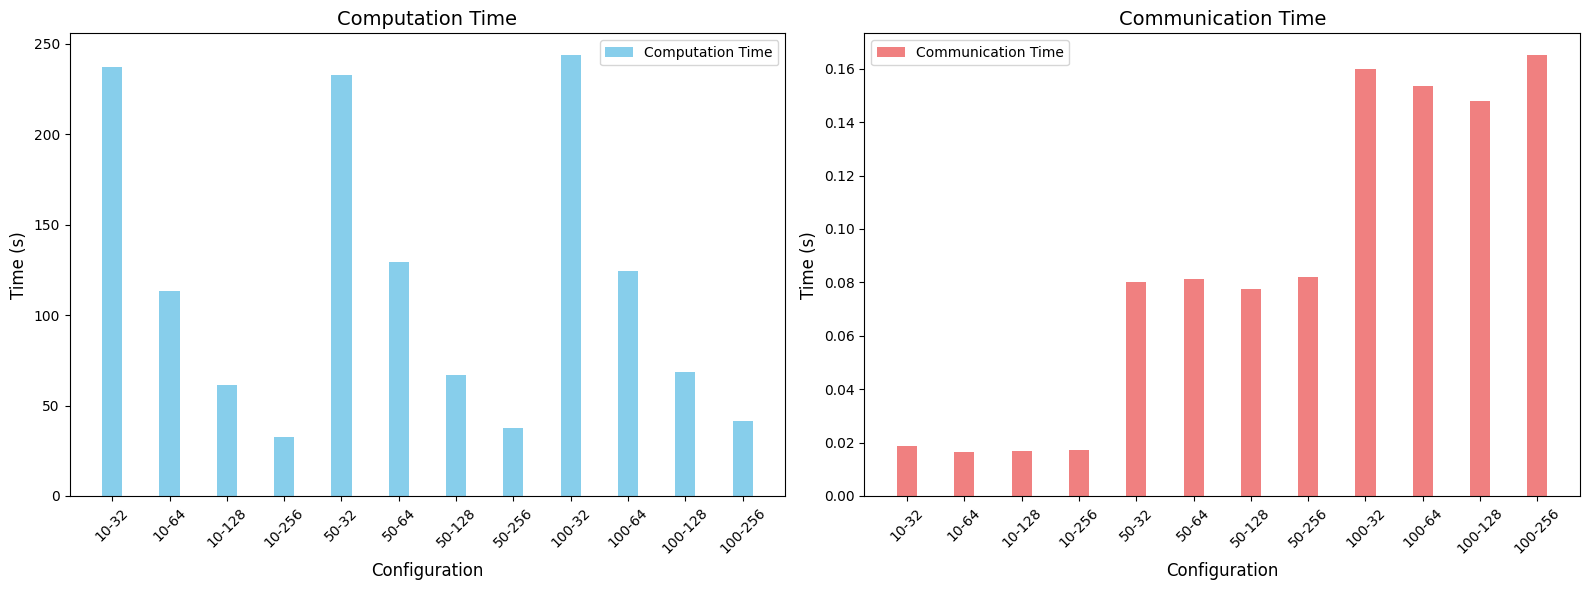


Computation and communication times for each configuration:
Configuration  Computation_Time(s)  Communication_Time(s)
        10-32           237.093256               0.018605
        10-64           113.245962               0.016365
       10-128            61.352118               0.017025
       10-256            32.696474               0.017046
        50-32           232.842842               0.080220
        50-64           129.106670               0.081274
       50-128            66.814687               0.077650
       50-256            37.621351               0.081959
       100-32           243.477426               0.159909
       100-64           124.161852               0.153359
      100-128            68.335618               0.148020
      100-256            41.179499               0.165011


In [32]:
#3Computation vs. Communication Time

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Define base directory
base_dir = '/global/homes/b/billmj/fl_unsw/experiments'

def parse_experiment_name(folder_name):
    parts = folder_name.split('_')
    num_clients = int(parts[2].replace('clients', ''))
    batch_size = int(parts[3].replace('batchsize', ''))
    return num_clients, batch_size

def load_experiment_data(exp_dir):
    comm_metrics = pd.read_csv(os.path.join(exp_dir, 'communication_metrics.csv'))
    num_clients, batch_size = parse_experiment_name(os.path.basename(exp_dir))
    
    comm_metrics['experiment'] = f'{num_clients}clients_{batch_size}batchsize'
    comm_metrics['num_clients'] = num_clients
    comm_metrics['batch_size'] = batch_size
    
    return comm_metrics

all_comm_metrics = []

for exp_folder in os.listdir(base_dir):
    if exp_folder.startswith('baseline_experiment_'):
        exp_dir = os.path.join(base_dir, exp_folder)
        comm_metrics = load_experiment_data(exp_dir)
        all_comm_metrics.append(comm_metrics)

comm_metrics_df = pd.concat(all_comm_metrics, ignore_index=True)

# Compute the total computation and communication times for each configuration
total_computation_time = comm_metrics_df.groupby(['num_clients', 'batch_size'])['Computation_Time(s)'].sum().reset_index()
total_communication_time = comm_metrics_df.groupby(['num_clients', 'batch_size'])['Communication_Time(s)'].sum().reset_index()

# Merge the two DataFrames
merged_df = pd.merge(total_computation_time, total_communication_time, on=['num_clients', 'batch_size'])

# Create configuration labels
merged_df['Configuration'] = merged_df['num_clients'].astype(str) + '-' + merged_df['batch_size'].astype(str)

# Plot the data side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

bar_width = 0.35
index = np.arange(len(merged_df))

# Plot computation time
ax1.bar(index, merged_df['Computation_Time(s)'], bar_width, label='Computation Time', color='skyblue')
ax1.set_ylabel('Time (s)', fontsize=12)
ax1.set_xlabel('Configuration', fontsize=12)  # Set x-axis label for computation time
ax1.set_title('Computation Time', fontsize=14)
ax1.set_xticks(index)
ax1.set_xticklabels(merged_df['Configuration'], rotation=45)
ax1.legend()

# Plot communication time
ax2.bar(index, merged_df['Communication_Time(s)'], bar_width, label='Communication Time', color='lightcoral')
ax2.set_xlabel('Configuration', fontsize=12)
ax2.set_ylabel('Time (s)', fontsize=12)  # Set y-axis label for communication time
ax2.set_title('Communication Time', fontsize=14)
ax2.set_xticks(index)
ax2.set_xticklabels(merged_df['Configuration'], rotation=45)
ax2.legend()

plt.tight_layout()
plt.show()

print("\nComputation and communication times for each configuration:")
print(merged_df[['Configuration', 'Computation_Time(s)', 'Communication_Time(s)']].to_string(index=False))


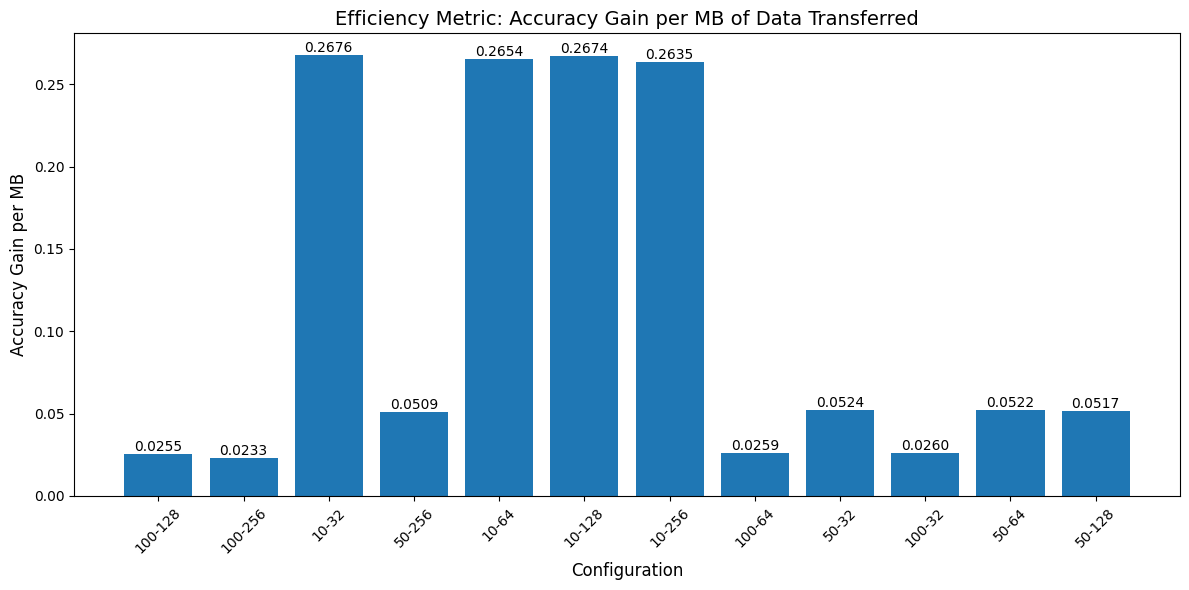


Efficiency metrics for each configuration:
 num_clients  batch_size  Accuracy  Total_Data_Transferred(MB)  Efficiency
         100         128  0.938544                   36.815643    0.025493
         100         256  0.857776                   36.815643    0.023299
          10          32  0.985061                    3.681564    0.267566
          50         256  0.937572                   18.407822    0.050933
          10          64  0.976984                    3.681564    0.265372
          10         128  0.984575                    3.681564    0.267434
          10         256  0.970061                    3.681564    0.263492
         100          64  0.953483                   36.815643    0.025899
          50          32  0.965082                   18.407822    0.052428
         100          32  0.956337                   36.815643    0.025976
          50          64  0.960527                   18.407822    0.052180
          50         128  0.952268                   18.

In [14]:
4# Efficiency Metric
# Calculate efficiency metric: accuracy gain per MB of data transferred
efficiency_df = final_metrics_df[final_metrics_df['Round'] == 15].merge(
    comm_metrics_df.groupby(['num_clients', 'batch_size'])['Total_Data_Transferred(MB)'].sum().reset_index(),
    on=['num_clients', 'batch_size']
)
efficiency_df['Efficiency'] = efficiency_df['Accuracy'] / efficiency_df['Total_Data_Transferred(MB)']

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(efficiency_df)), efficiency_df['Efficiency'], align='center')
plt.xlabel('Configuration', fontsize=12)
plt.ylabel('Accuracy Gain per MB', fontsize=12)
plt.title('Efficiency Metric: Accuracy Gain per MB of Data Transferred', fontsize=14)
plt.xticks(range(len(efficiency_df)), 
           [f"{row['num_clients']}-{row['batch_size']}" for _, row in efficiency_df.iterrows()], 
           rotation=45)

# Annotate bars with values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.show()

print("\nEfficiency metrics for each configuration:")
print(efficiency_df[['num_clients', 'batch_size', 'Accuracy', 'Total_Data_Transferred(MB)', 'Efficiency']].to_string(index=False))

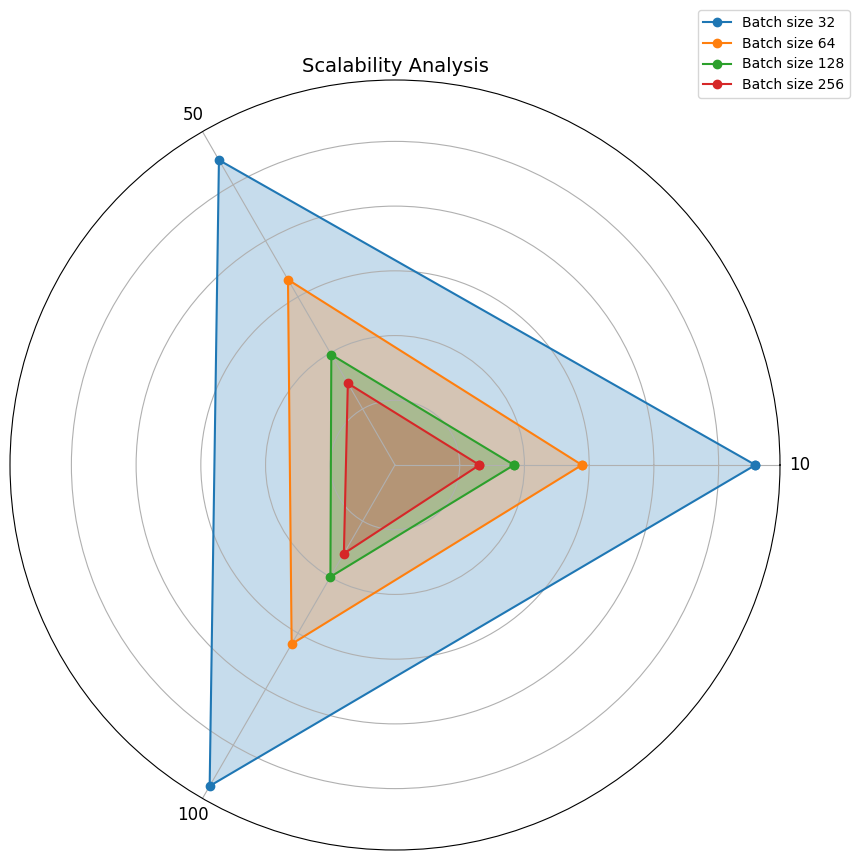


Total execution time for each configuration:
 num_clients  batch_size  Round_Total_Time(s)
          10          32           278.441733
          10          64           144.407706
          10         128            91.921991
          10         256            65.239563
          50          32           272.033247
          50          64           165.353951
          50         128            98.400492
          50         256            72.882778
         100          32           286.368500
         100          64           159.696965
         100         128            99.780235
         100         256            78.998274


In [35]:
#5.Scalability 

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define base directory
base_dir = '/global/homes/b/billmj/fl_unsw/experiments'

def parse_experiment_name(folder_name):
    parts = folder_name.split('_')
    num_clients = int(parts[2].replace('clients', ''))
    batch_size = int(parts[3].replace('batchsize', ''))
    return num_clients, batch_size

def load_experiment_data(exp_dir):
    comm_metrics = pd.read_csv(os.path.join(exp_dir, 'communication_metrics.csv'))
    num_clients, batch_size = parse_experiment_name(os.path.basename(exp_dir))
    
    comm_metrics['experiment'] = f'{num_clients}clients_{batch_size}batchsize'
    comm_metrics['num_clients'] = num_clients
    comm_metrics['batch_size'] = batch_size
    
    return comm_metrics

all_comm_metrics = []

for exp_folder in os.listdir(base_dir):
    if exp_folder.startswith('baseline_experiment_'):
        exp_dir = os.path.join(base_dir, exp_folder)
        comm_metrics = load_experiment_data(exp_dir)
        all_comm_metrics.append(comm_metrics)

comm_metrics_df = pd.concat(all_comm_metrics, ignore_index=True)

# Compute the total execution time for each configuration
total_time = comm_metrics_df.groupby(['num_clients', 'batch_size'])['Round_Total_Time(s)'].sum().unstack()

# Radar chart requires equal spacing for each axis
labels = total_time.index.astype(str).tolist()
num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Plot the radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Plot each batch size
for batch_size in total_time.columns:
    values = total_time[batch_size].tolist()
    values += values[:1]  # Complete the loop
    ax.plot(angles, values, label=f'Batch size {batch_size}', marker='o')
    ax.fill(angles, values, alpha=0.25)

# Add labels and title
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=12)
ax.set_yticklabels([])
ax.set_title('Scalability Analysis', fontsize=14)
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

plt.show()

print("\nTotal execution time for each configuration:")
total_time = comm_metrics_df.groupby(['num_clients', 'batch_size'])['Round_Total_Time(s)'].sum().reset_index()
print(total_time.to_string(index=False))



 Each line represents a batch size, and each axis represents the number of clients.

Key insights:
1. **Highest Total Execution Time**:
   - Batch Size 32 has the highest execution times, with 10 clients.
2. **Lowest Total Execution Time**:
   - Batch Size 256 has the lowest execution times, with 100 clients.
3. **Scalability**:
   - Larger batch sizes (128 and 256) maintain lower execution times and scale better with more clients.
   - Smaller batch sizes (32 and 64) exhibit higher execution times and poorer scalability as client numbers increase.

